# Compare sPlotOpen to published trait maps

In order to assess the added value of citizen science data for global trait mapping, we compared the trait products generated in this study with trait products from previous studies obtained via extrapolations (see manuscript for references and details).

**Traits**: Leaf N/mass, Leaf N/area, SLA

This section covers:

- Load GeoTiff published maps
- Calculate weighted r
- Comparison of new iNaturalist maps to Schiller maps

In [ ]:
# packages
import os
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for calculating grid areas
from pyproj import Proj # allows for different projections 
from shapely.geometry import shape # for calculating areas

## Load published maps from GeoTiff

We use xarray to load the geotiffs containing the published maps:


In [18]:
from os import listdir
from os.path import isfile, join
path = "published_maps/05deg/"
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()

In [19]:
import xarray as xr

In [20]:
files

['other_nit_05deg.tif', 'other_nita_05deg.tif', 'other_sla_05deg.tif']

In [21]:
def cubeFile(file):
    name = file.replace(".tif","")
    sr = xr.open_dataset(path + file,engine = "rasterio",chunks = 1024)
    sr = sr.assign_coords({"variable":name})
    return sr

da = xr.concat([cubeFile(x) for x in files],dim = "variable")

In [22]:
da

<xarray.Dataset>
Dimensions:      (band: 6, x: 720, y: 360, variable: 3)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6
  * x            (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * y            (y) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    spatial_ref  int64 0
  * variable     (variable) <U16 'other_nit_05deg' ... 'other_sla_05deg'
Data variables:
    band_data    (variable, band, y, x) float32 dask.array<chunksize=(1, 6, 360, 720), meta=np.ndarray>

Check output by visualizing one band:

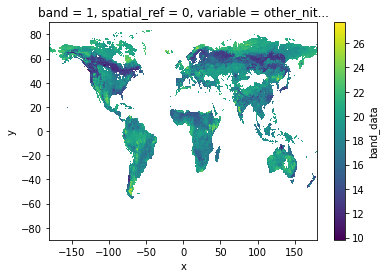

In [24]:
da.sel(band = 1).band_data.sel(variable = 'other_nit_05deg').plot.imshow()

## Calculate weighted r for each published map in relation to sPlotOpen

In [25]:
def lat_weights(lat_unique, deg):
    
    from pyproj import Proj
    from shapely.geometry import shape
    
    # determine weights per grid cell based on longitude
    # keep only one exemplary cell at each distance from equator
    # weights per approximated area of grid size depending on distance from equator
    
    # make dictionary
    weights = dict()

    for j in lat_unique:
        
        # the four corner points of the grid cell
        p1 = (0 , j+(deg/2))
        p2 = (deg , j+(deg/2) )
        p3 = (deg, j-(deg/2))
        p4 = (0, j-(deg/2) )
        
    
        # Calculate polygon surface area
        # https://stackoverflow.com/questions/4681737/how-to-calculate-the-area-of-a-polygon-on-the-earths-surface-using-python
        
        co = {"type": "Polygon", "coordinates": [[p1,p2,p3,p4]]}
        lat_1=p3[1]
        lat_2=p1[1]
        lat_0=(p1[1]+p3[1])/2
        lon_0=deg/2
        
        
        # Projection equal area used: https://proj.org/operations/projections/aea.html
        projection_string="+proj=aea +lat_1=" + str(lat_1) + " +lat_2=" + str(lat_2) + " +lat_0=" + str(lat_0) + " +lon_0=" + str(lon_0) 
        lon, lat = zip(*co['coordinates'][0])
        
        pa = Proj(projection_string)
        x, y = pa(lon, lat)
        cop = {"type": "Polygon", "coordinates": [zip(x, y)]}
        
        area = (shape(cop).area/1000000)

        # set coord to center of grid cell
        coord = j

        weights[coord] = area
    
    # turn area into proportion with area/max.area:
    
    max_area = max(weights.values())
    for key in weights.keys():
        
        weights[key] = weights[key]/max_area
        
    return weights

In [26]:
def weighted_r(df, col_1, col_2, col_lat, weights, r2=False):
    
    # map weights to dataframe
    df['Weights'] = df[col_lat].map(weights)
        
    # calculate weighted correlation 
    # https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.DescrStatsW.html
    import statsmodels.api as statmod
    
    d1 = statmod.stats.DescrStatsW( df[[col_1, col_2]], df['Weights'] )
        
    corr = d1.corrcoef[0][1]
    
    # optional
    # calculate r2
    if r2 == True:
        corr = corr**2
    
    return corr

Calculate weighted r for Leaf N per mass, per area, and for specific leaf area (SLA)

In [27]:
other_trait = ['other_nit_05deg', 'other_nita_05deg', 'other_sla_05deg']
trait = ['Leaf N per mass', 'Leaf N per area', 'SLA']

r_all = pd.DataFrame(columns=trait)

deg = 0.5

for b in [0,1,2,3,4,5,6]:
    
    r_grid = []
    
    for t in [0,1,2]:
        
        # open sPlotData

        filename="grid_means_" + str(deg) + "_deg.csv"
        raster_means = pd.read_csv(filename)
        raster_means = raster_means[~raster_means.isin([np.nan, np.inf, -np.inf]).any(1)]
        
        # subset only one trait
        raster_means_trait = raster_means[raster_means['Trait']==trait[t]]
        
        lat_unique = raster_means_trait['y_bin'].unique()
        weights = lat_weights(lat_unique, deg=deg)
         
        
        if b == 0:
            # iNaturalist Data
            # drop nan's
            raster_means_trait = raster_means_trait.dropna()
            
            # calculate weighted r
            r_trait = weighted_r(raster_means_trait, "TraitValue_sPlot", "TraitValue_iNat", "y_bin", weights)

            r_grid.append(r_trait)
            
        else:
            # published data
        
            df = da.sel(band = b).band_data.sel(variable = other_trait[t]).to_dataset().to_dataframe().reset_index()
            
            df['variable'] = trait[t]
        
            raster_means_trait = pd.merge(raster_means_trait, df, left_on = ["Trait","x_bin", "y_bin"], right_on = ["variable", "x", "y"])
            raster_means_trait.drop(["variable", "x", "y", "spatial_ref", "TraitValue_iNat", "band"], axis=1, inplace=True)
            
            # log band_data
            raster_means_trait['band_data'] = np.log(raster_means_trait['band_data']) 
            
            # drop nan's
            raster_means_trait = raster_means_trait.dropna()
            raster_means_trait = raster_means_trait[~raster_means_trait.isin([np.nan, np.inf, -np.inf]).any(1)]
            
            if raster_means_trait.empty:
                
                r_trait = 'NaN'
                r_grid.append(r_trait)
            
            else:
            
                # calculate weighted r
                r_trait = weighted_r(raster_means_trait, "TraitValue_sPlot", "band_data", "y_bin", weights)

            
                # add to trait r's
                r_grid.append(r_trait)
    
        
    s = pd.Series(r_grid, index=r_all.columns)
    
    # add new series of r at a certain resolution to df 
    r_all = r_all.append(s, ignore_index=True)
        

Order of data sets in df:

- Leaf N per mass / Leaf N per area: 
    0. iNaturalis
    1. Butler
    2. Boonman
    3. Moreno
    4. Schiller
    5. Vallicrosa
    
    
- SLA: 
    0. iNaturalist
    1. Bodegom
    2. Butler
    3. Boonman
    4. Madani
    5. Moreno
    6. Schiller

We exclude the Schiller maps in our interpretation, since they are not extrapolated.

In [28]:
# correlations (r)
r_all

,Leaf N per mass,Leaf N per area,SLA
0,0.369761,0.533832,0.511926
1,0.240489,0.413235,0.366148
2,0.084643,0.451688,0.309404
3,0.253438,0.461684,0.481250
4,0.402281,0.547655,-0.023888
5,0.235077,-0.061551,0.396958
6,NaN,NaN,0.537115
